# (??) Regression -- DCI

**Motivation**: Apply DCI criteria using linear regression. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from model.train_vae import TrainerVAE, ConfigTrain
from model.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Load model

In [2]:
%%time

from model.utils_model import load_model

model_name = 'k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)'
fit_name = 'NoL1_ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.001)_gr(1000)_(2023_03_31,17:02)'
tr, metadata = load_model(
    model_name=model_name,
    fit_name=fit_name,
    device='cuda:0',
    verbose=True,
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 17.0 M

CPU times: user 55 s, sys: 3.61 s, total: 58.6 s
Wall time: 10.4 s


In [4]:
print(list(metadata.items())[:2])

[('checkpoint', 1050), ('global_step', 84000)]

In [5]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 35.2 s, sys: 6.92 s, total: 42.1 s
Wall time: 41.6 s


In [6]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{'epe': {'vae': 4.21, 'ema': 3.7}, 'kl': {'vae': 29.56, 'ema': 29.54}}

fig/sample (VAE)

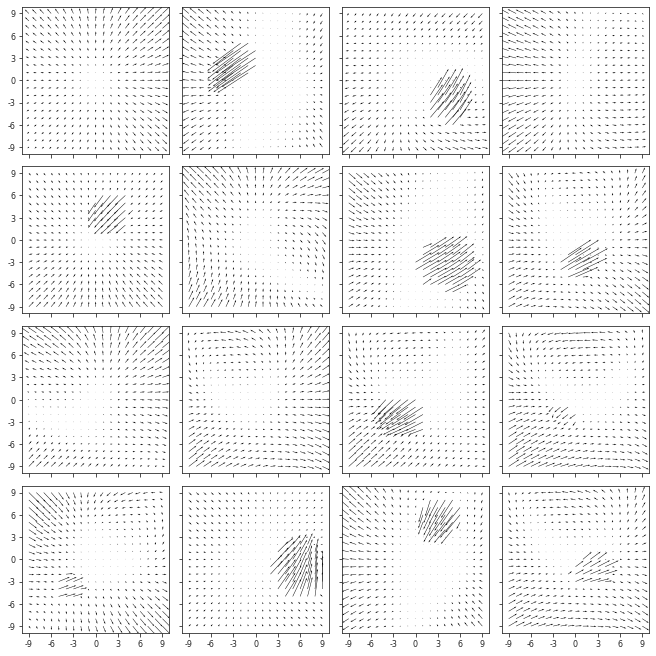

fig/sample (EMA)

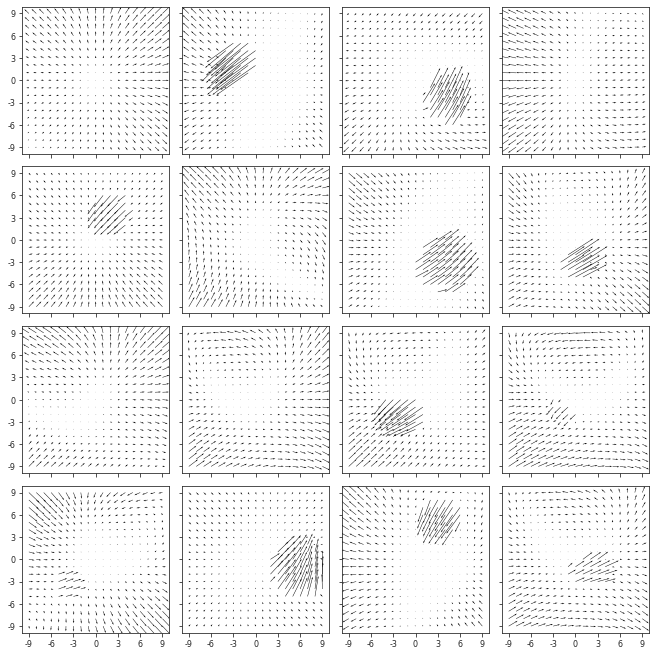

----------------------------------------------------------------------

fig/regression (VAE)

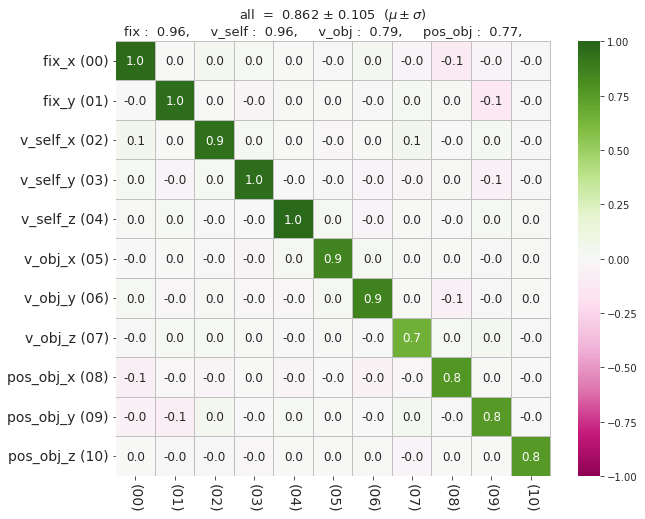

fig/regression (EMA)

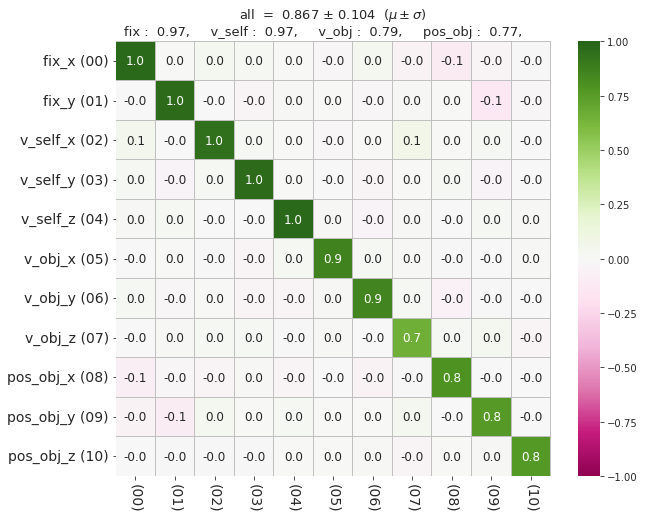

----------------------------------------------------------------------

fig/mutual_info (VAE)

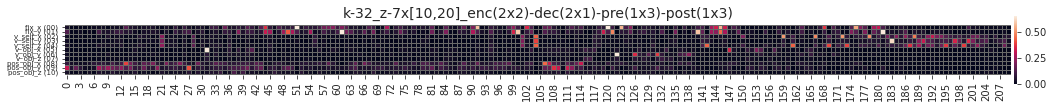

fig/mutual_info (EMA)

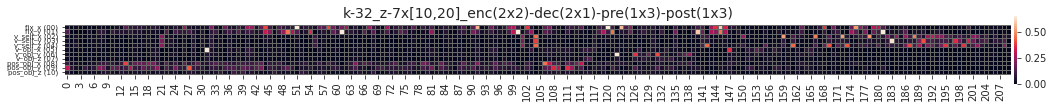

----------------------------------------------------------------------

In [7]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

## Latents hist

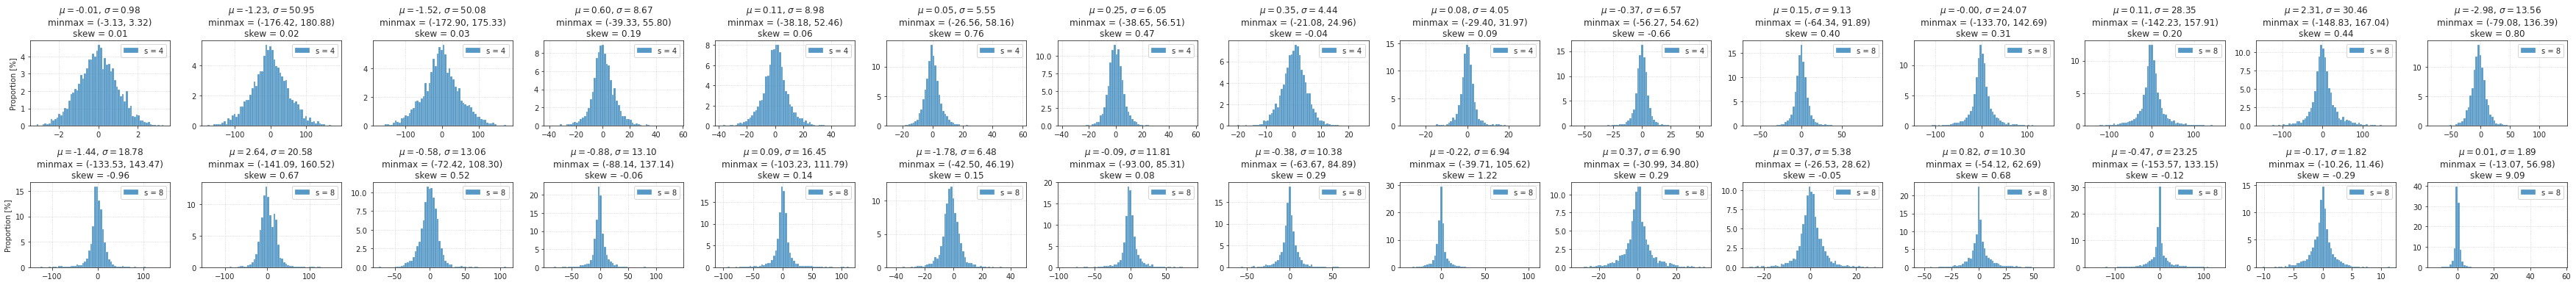

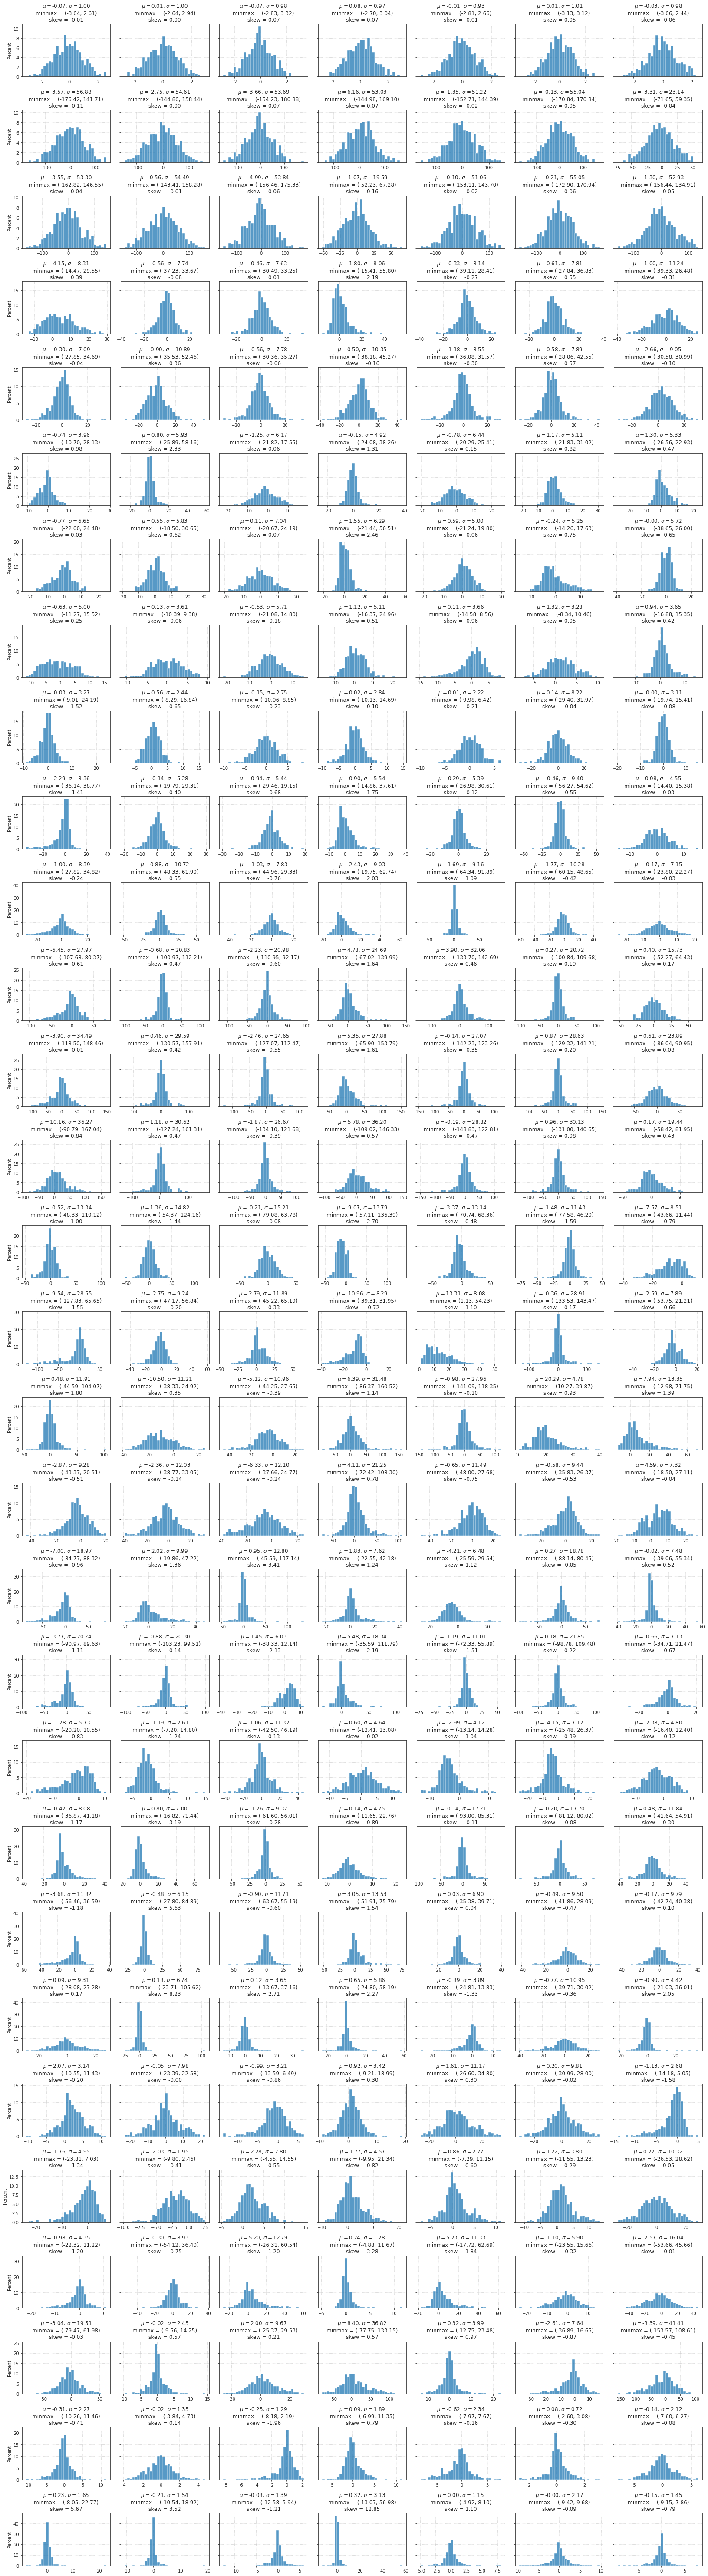

In [8]:
scales, _ = tr.model.latent_scales()
plot_latents_hist(val_ema['z_sample'], scales)
plot_latents_hist_full(val_ema['z_sample'], scales);

(128, 7, -179.43686)

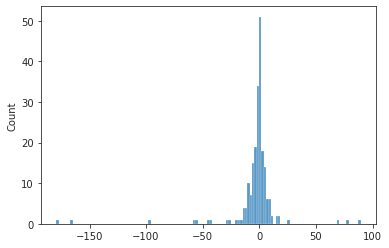

In [9]:
i, zz = np.unravel_index(np.argmin(val_ema['z_sample']), val_ema['z_sample'].shape)
sns.histplot(val['z_sample'][i]);
i, zz, val['z_sample'][i, zz]

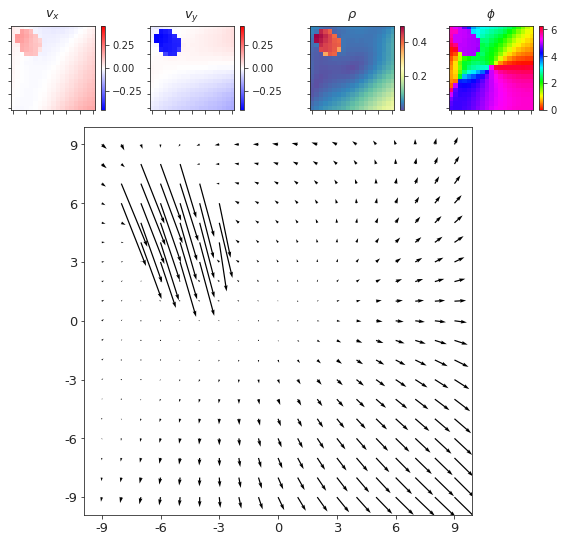

In [10]:
show_opticflow_full(val_ema['x_sample'][i]);

(36, 9, 175.50671)

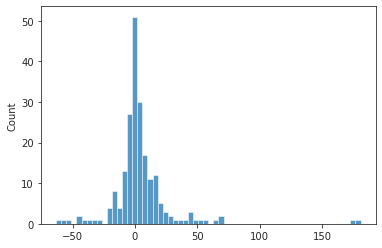

In [11]:
i, zz = np.unravel_index(np.argmax(val_ema['z_sample']), val_ema['z_sample'].shape)
sns.histplot(val_ema['z_sample'][i]);
i, zz, val['z_sample'][i, zz]

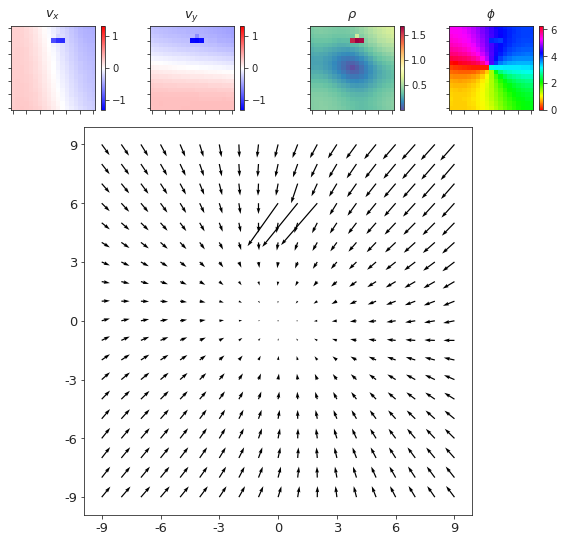

In [12]:
show_opticflow_full(val_ema['x_sample'][i]);

In [13]:
torch.abs(torch.cat(tr.model_ema.all_log_norm)).sum()

tensor(825.0345, device='cuda:0', grad_fn=<SumBackward0>)

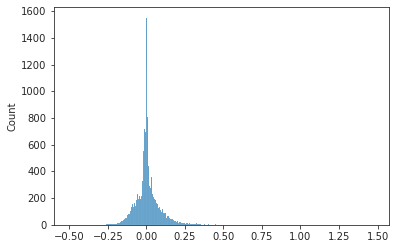

In [14]:
a = to_np(torch.cat(tr.model_ema.all_log_norm))
sns.histplot(a);

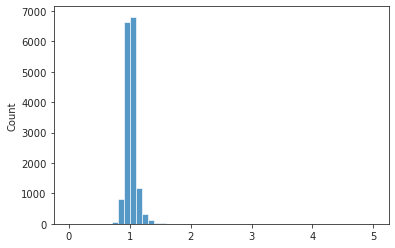

In [15]:
all_norms = to_np(torch.cat(tr.model_ema.all_log_norm).exp())
ax = sns.histplot(all_norms, bins=np.linspace(0, 5, 51));

In [16]:
np.max(all_norms)

4.358715

In [17]:
print(f"{np.round((all_norms > 1.5).sum() / len(all_norms) * 100, 1)} % of them are greated than 1.5")

0.2 % of them are greated than 1.5

In [18]:
w2p = {}
norms_expand = {}
for i, layer in enumerate(tr.model_ema.expand):
    w2p[i] = to_np(layer.weight)
    _norm = to_np(torch.linalg.vector_norm(layer.weight, dim=[0, 2, 3]))
    norms_expand[i] = list(_norm)
print({i: (np.round(np.mean(v), 3), np.round(v, 3)) for i, v in norms_expand.items()})

{
    0: (0.487, array([0.225, 0.574, 0.529, 0.516, 0.553, 0.553, 0.46 ], dtype=float32)),
    1: (0.672, array([0.292, 0.734, 0.708, 0.297, 0.896, 0.788, 0.986], dtype=float32)),
    2: (0.785, array([0.72 , 0.751, 0.528, 0.924, 1.028, 0.518, 1.026], dtype=float32)),
    3: (0.695, array([0.68 , 0.776, 0.727, 0.563, 0.592, 0.71 , 0.815], dtype=float32)),
    4: (0.634, array([0.611, 0.522, 0.706, 0.645, 0.651, 0.638, 0.666], dtype=float32)),
    5: (0.609, array([0.62 , 0.52 , 0.558, 0.688, 0.609, 0.556, 0.712], dtype=float32)),
    6: (0.647, array([0.697, 0.73 , 0.563, 0.711, 0.603, 0.607, 0.619], dtype=float32)),
    7: (0.639, array([0.611, 0.652, 0.705, 0.671, 0.586, 0.684, 0.565], dtype=float32)),
    8: (0.647, array([0.647, 0.701, 0.626, 0.64 , 0.623, 0.714, 0.581], dtype=float32)),
    9: (0.708, array([0.683, 0.724, 0.776, 0.765, 0.743, 0.665, 0.601], dtype=float32)),
    10: (0.976, array([1.108, 0.982, 0.941, 0.992, 1.095, 0.831, 0.883], dtype=float32)),
    11: (0.979, array([1.034, 1.073, 0.911, 0.956, 1.058, 0.969, 0.851], dtype=float32)),
    12: (1.005, array([0.824, 1.017, 0.99 , 1.127, 0.973, 1.012, 1.093], dtype=float32)),
    13: (0.968, array([0.647, 0.783, 1.139, 1.04 , 1.057, 1.068, 1.045], dtype=float32)),
    14: (0.882, array([0.757, 1.017, 0.871, 0.772, 1.129, 0.784, 0.841], dtype=float32)),
    15: (1.115, array([1.133, 1.114, 1.029, 1.081, 1.115, 1.143, 1.19 ], dtype=float32)),
    16: (1.08, array([0.98 , 1.099, 1.015, 1.106, 1.097, 1.139, 1.126], dtype=float32)),
    17: (1.039, array([1.068, 1.092, 1.028, 0.972, 0.989, 1.026, 1.095], dtype=float32)),
    18: (1.046, array([1.137, 0.94 , 0.953, 1.127, 0.926, 1.111, 1.126], dtype=float32)),
    19: (0.995, array([1.029, 1.17 , 1.017, 1.024, 0.875, 0.962, 0.886], dtype=float32)),
    20: (1.032, array([1.056, 0.944, 1.119, 1.135, 0.92 , 1.022, 1.029], dtype=float32)),
    21: (1.013, array([1.121, 1.061, 0.893, 1.049, 0.946, 1.069, 0.952], dtype=float32)),
    22: (1.004, array([0.879, 1.065, 1.063, 0.891, 0.988, 1.074, 1.066], dtype=float32)),
    23: (0.785, array([0.65 , 0.773, 0.725, 0.856, 0.862, 0.827, 0.803], dtype=float32)),
    24: (0.992, array([0.968, 0.99 , 0.982, 0.97 , 1.074, 0.929, 1.03 ], dtype=float32)),
    25: (1.094, array([0.99 , 1.093, 1.05 , 1.04 , 1.231, 1.139, 1.116], dtype=float32)),
    26: (1.024, array([1.036, 1.114, 0.96 , 1.097, 1.053, 0.931, 0.975], dtype=float32)),
    27: (1.369, array([1.541, 1.47 , 1.375, 1.255, 1.181, 1.363, 1.397], dtype=float32)),
    28: (0.972, array([0.965, 0.962, 1.003, 0.942, 0.984, 0.961, 0.989], dtype=float32)),
    29: (1.101, array([1.257, 1.199, 1.002, 0.927, 1.163, 1.056, 1.101], dtype=float32))
}

In [19]:
tr.model_ema.print()

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

In [20]:
tr.model_ema.stem.lognorm.exp()

tensor([1.0497, 1.0887, 1.0489, 1.0904, 1.0679, 1.0942, 1.0596, 1.2928, 1.0869,
        1.0374, 1.0526, 1.1363, 1.0988, 1.0656, 1.1812, 1.1073, 1.0784, 1.1583,
        1.2912, 1.1914, 1.0924, 1.0893, 1.1505, 1.0799, 1.0693, 1.0608, 1.1254,
        1.0826, 1.0680, 1.0648, 1.1327, 1.0848], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [21]:
w = to_np(tr.model_ema.out.weight)
w.shape

(2, 32, 3, 3)

In [22]:
torch.linalg.vector_norm(tr.model_ema.out.weight, dim=[1, 2, 3])

tensor([0.2801, 0.2957], device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

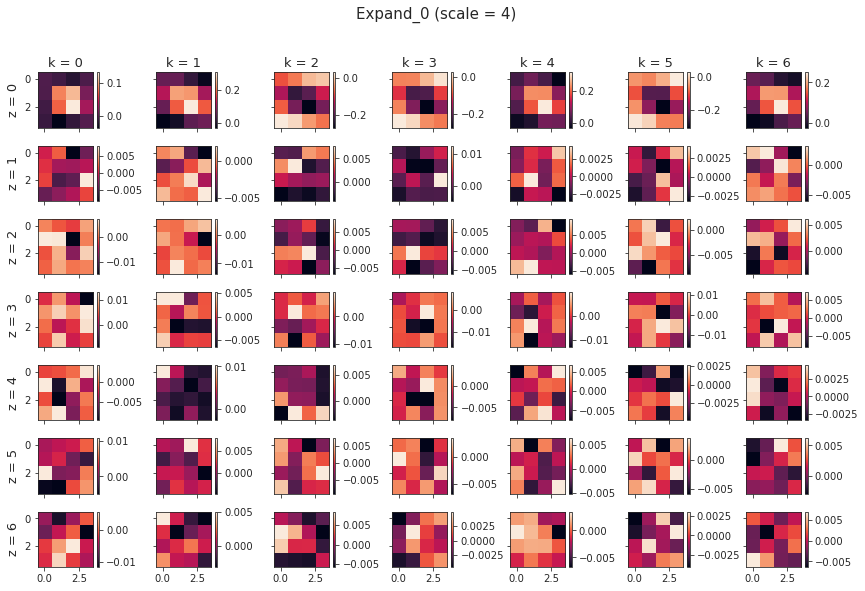

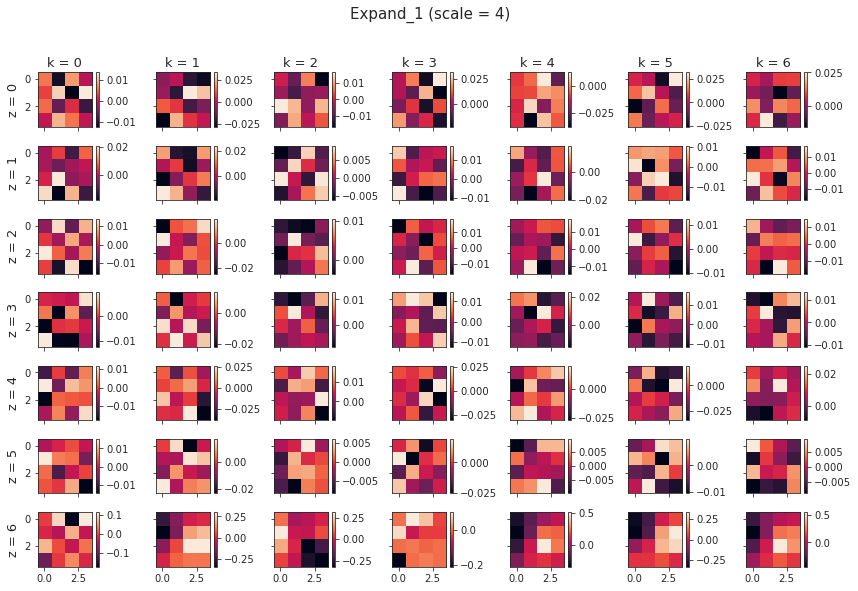

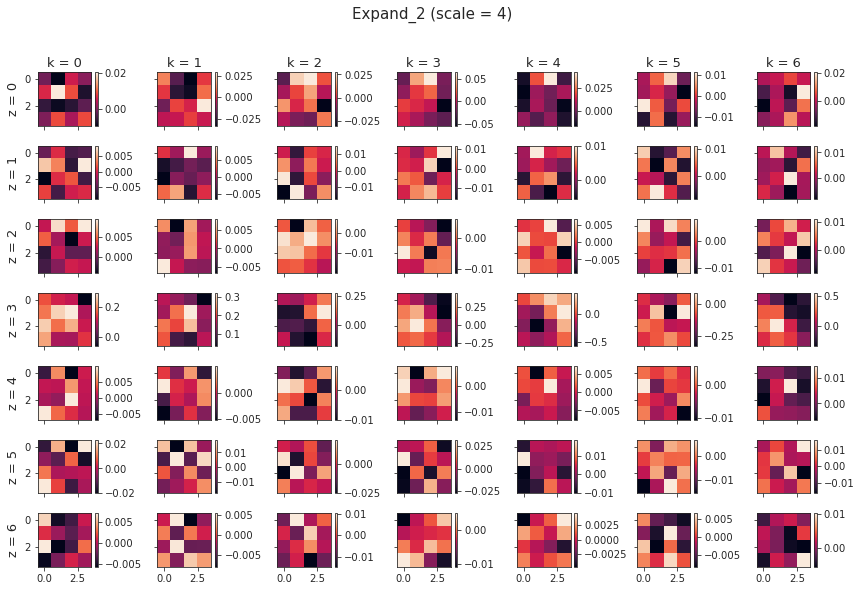

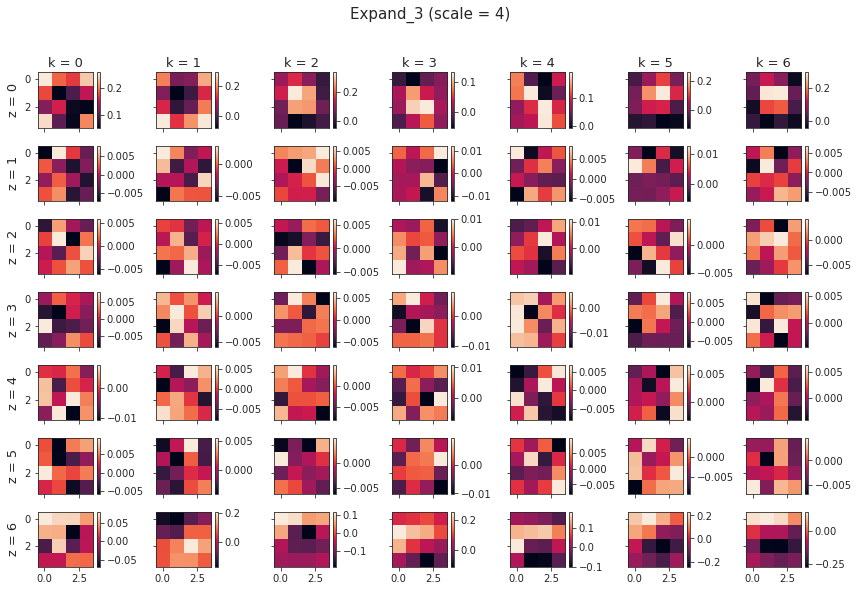

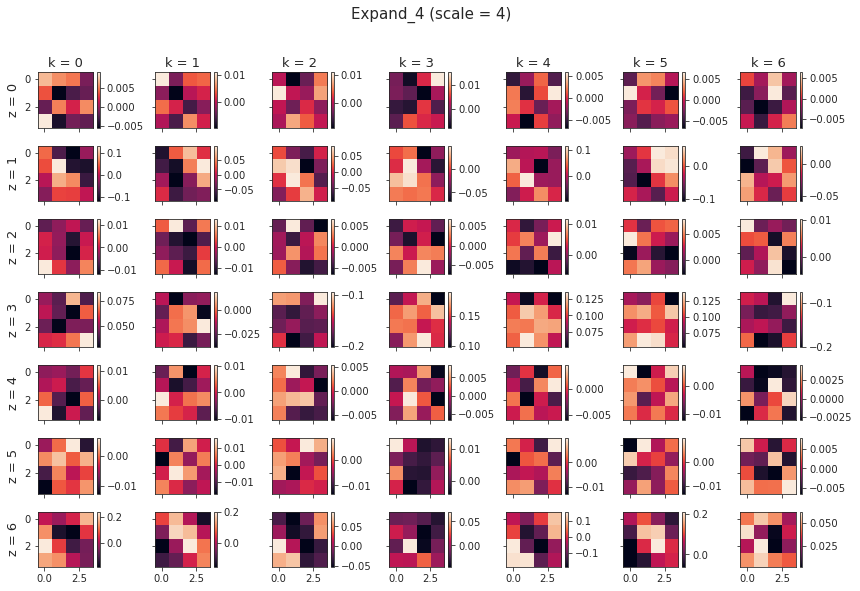

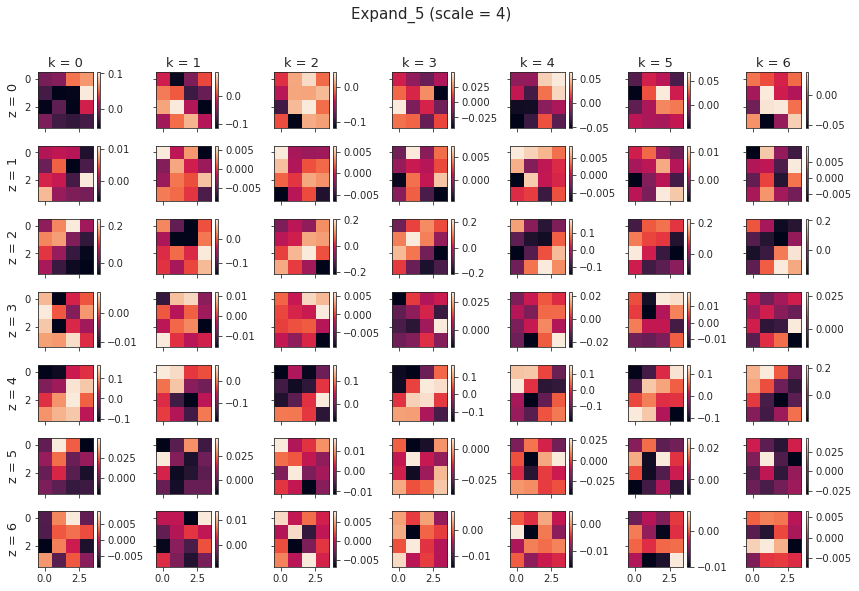

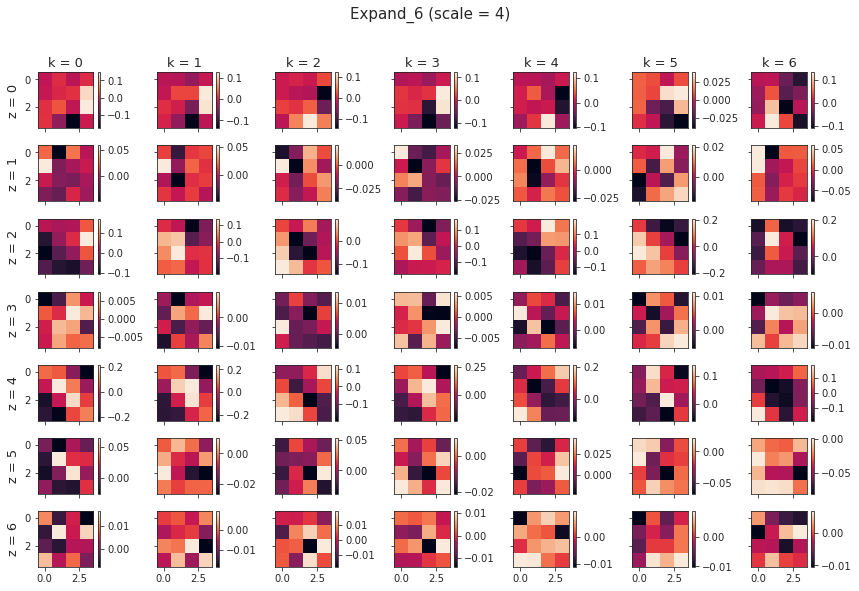

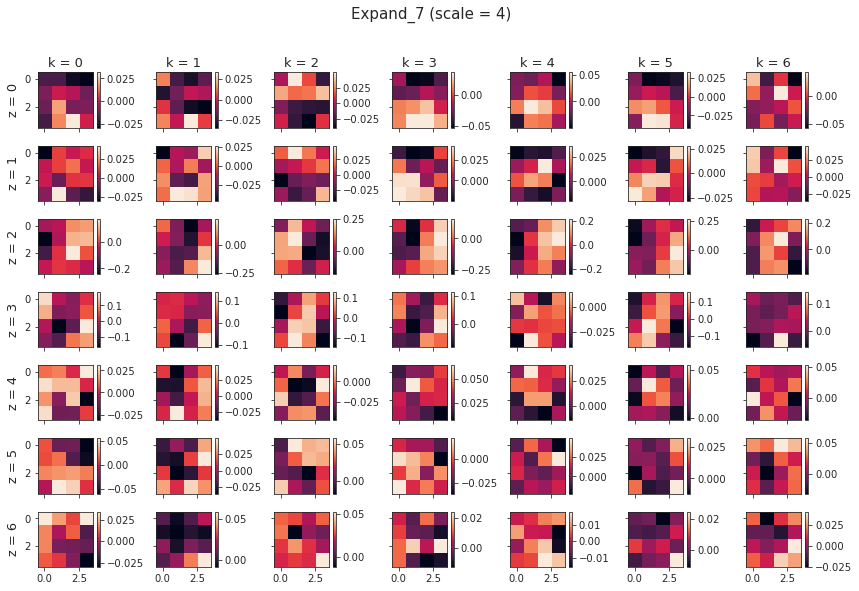

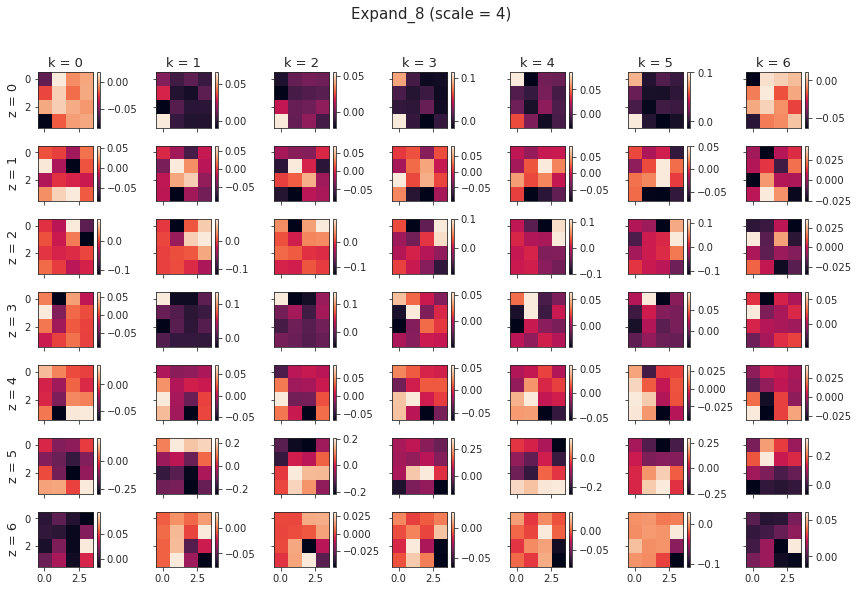

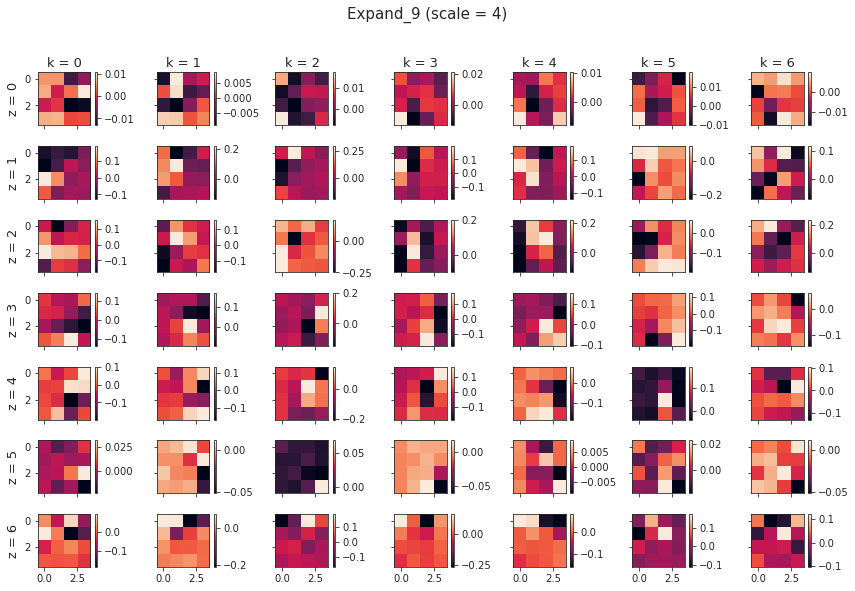

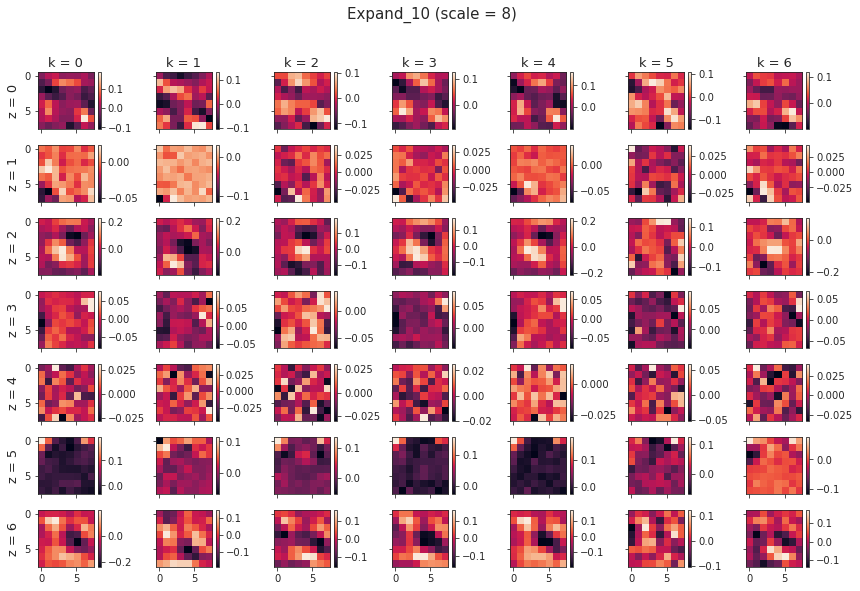

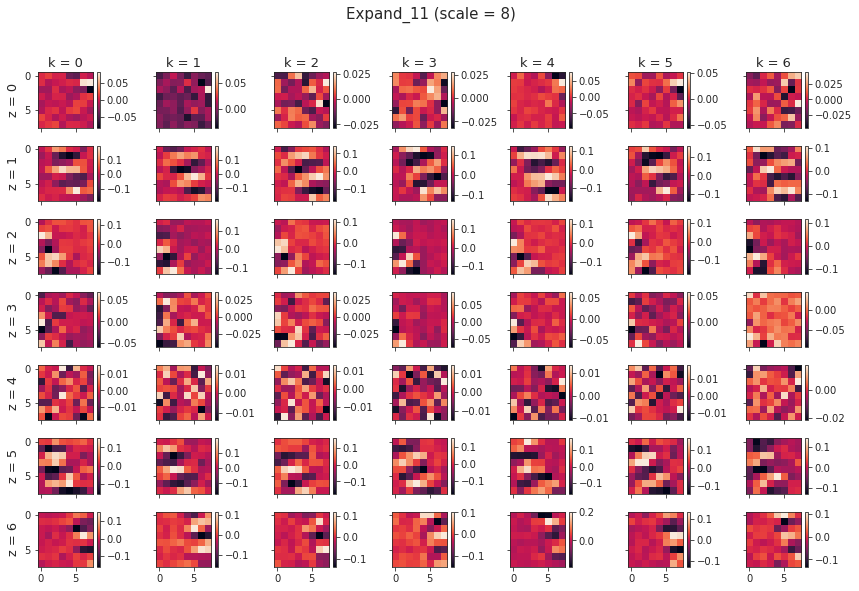

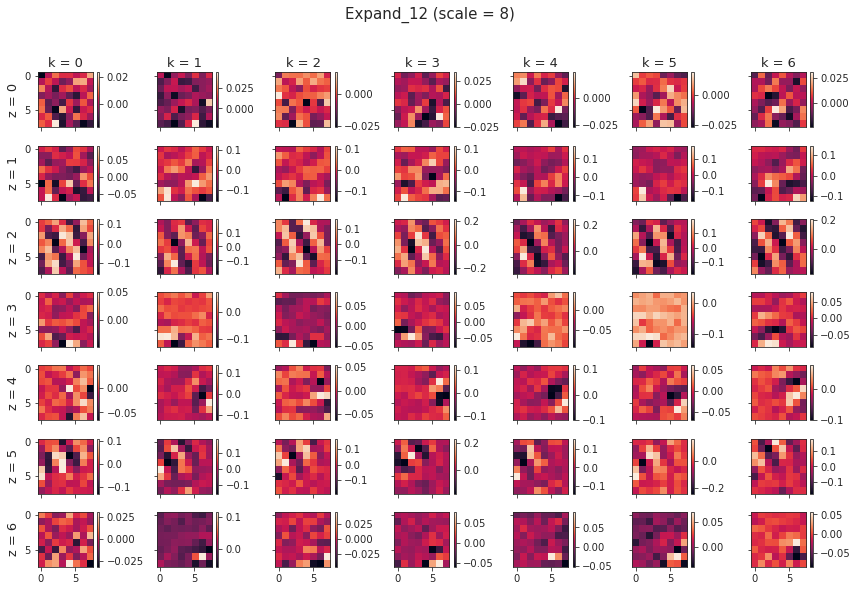

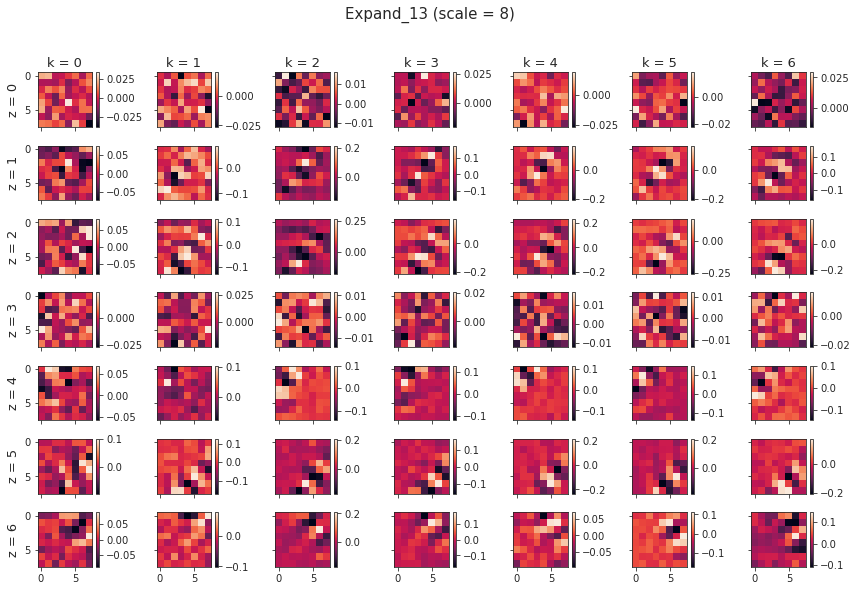

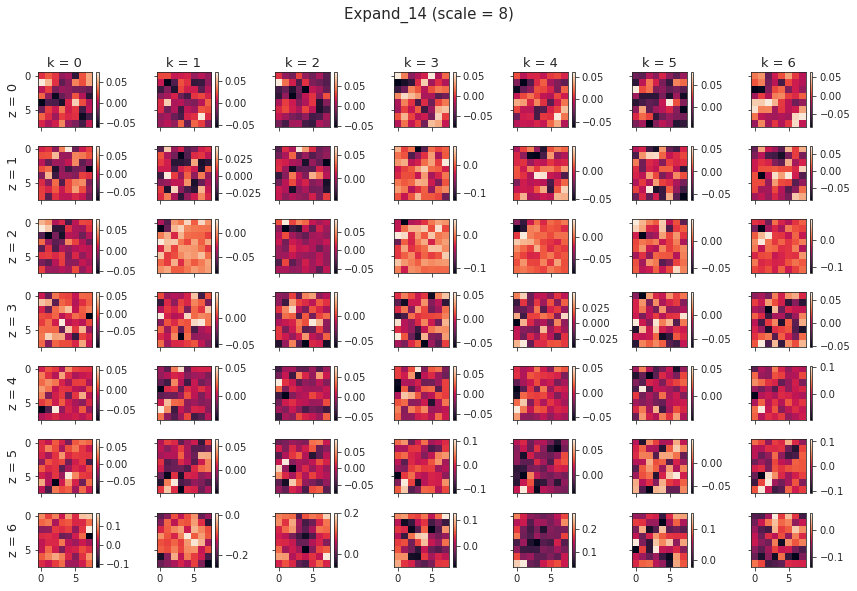

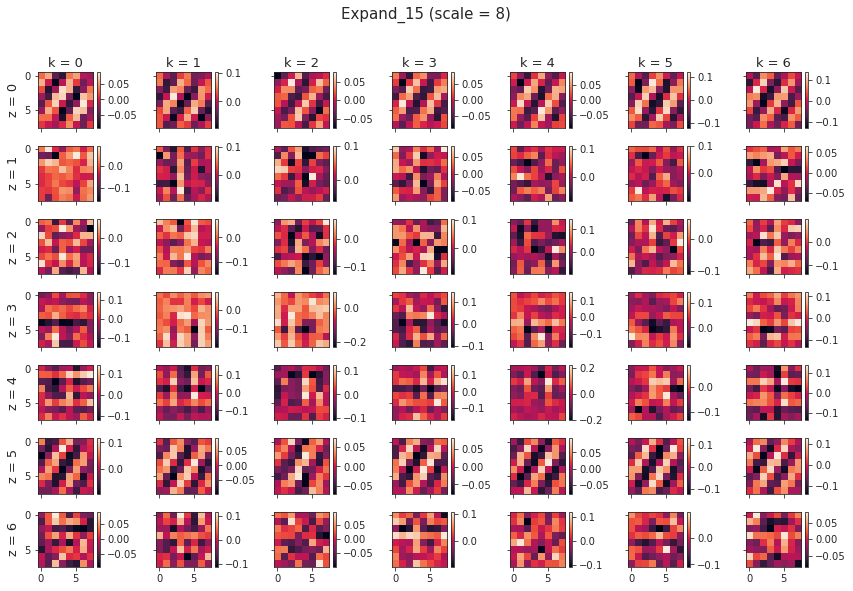

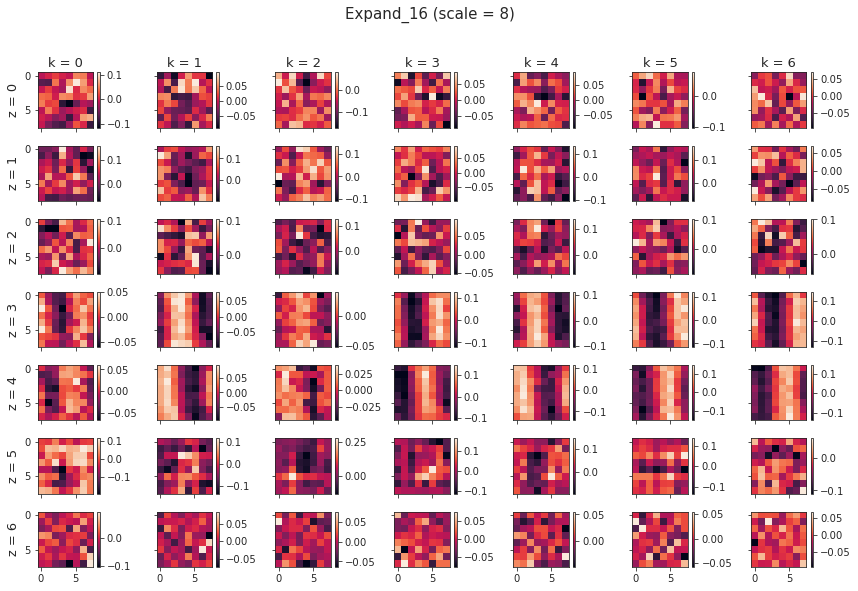

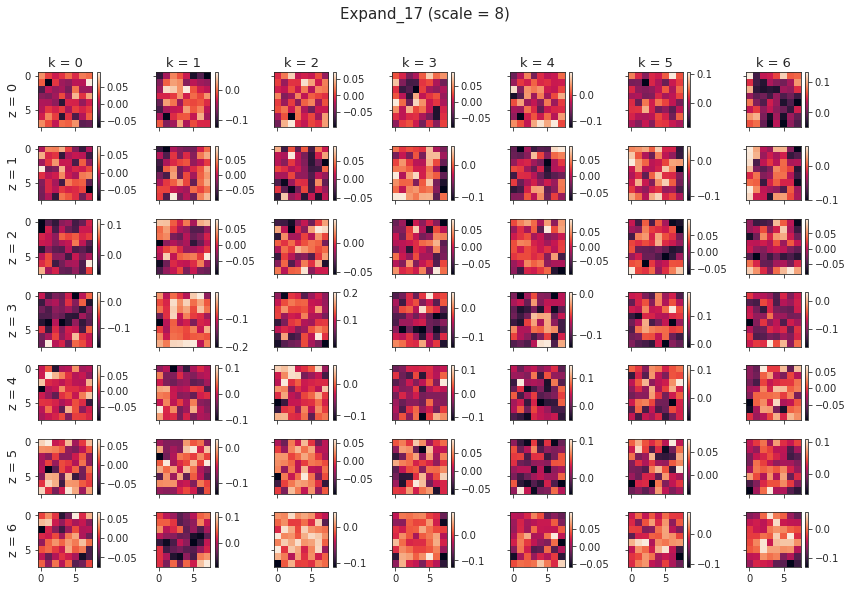

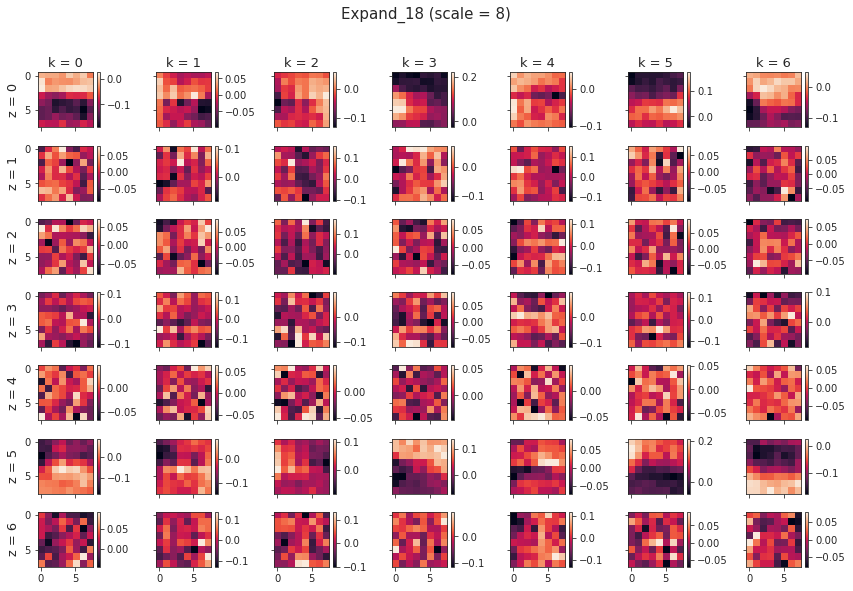

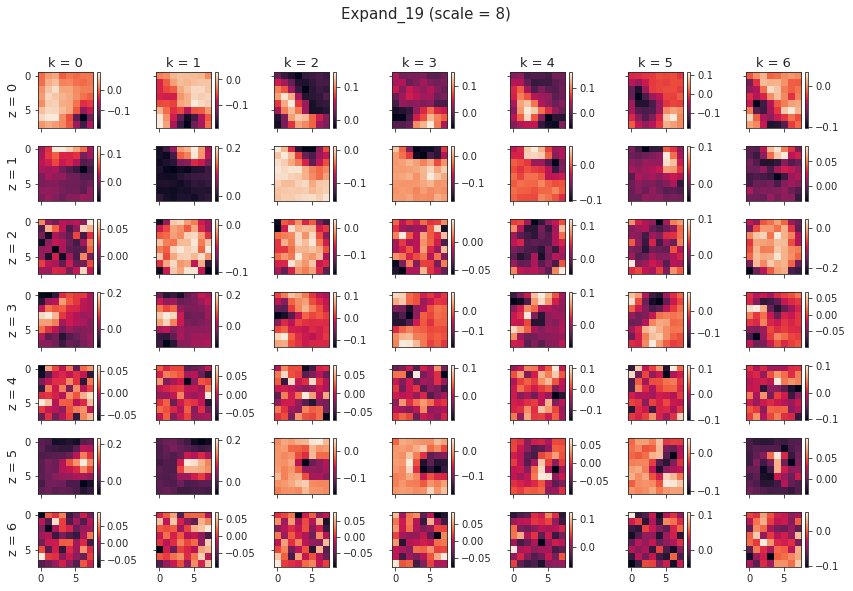

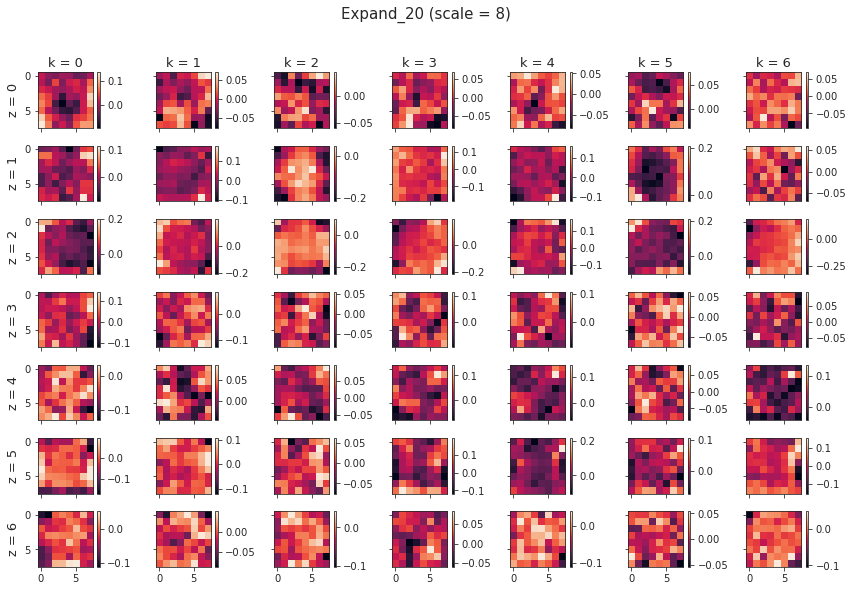

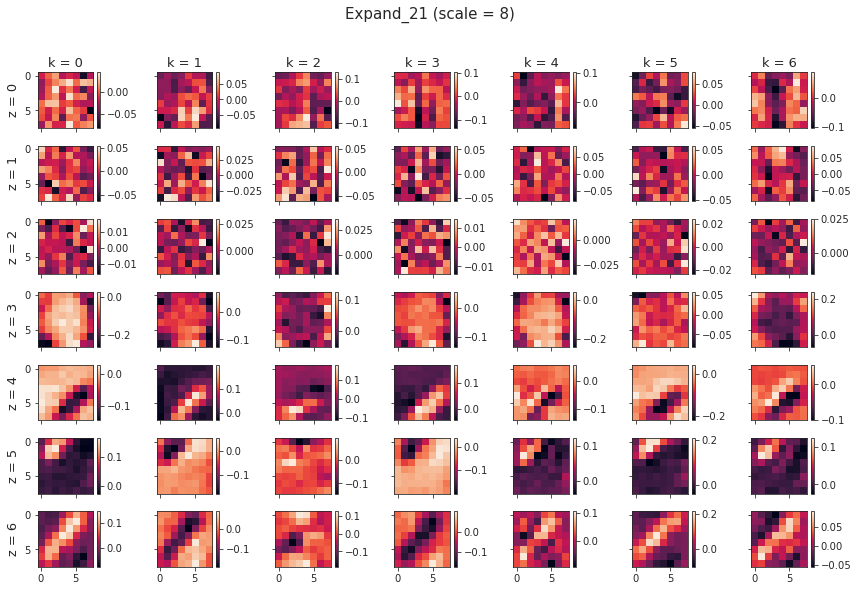

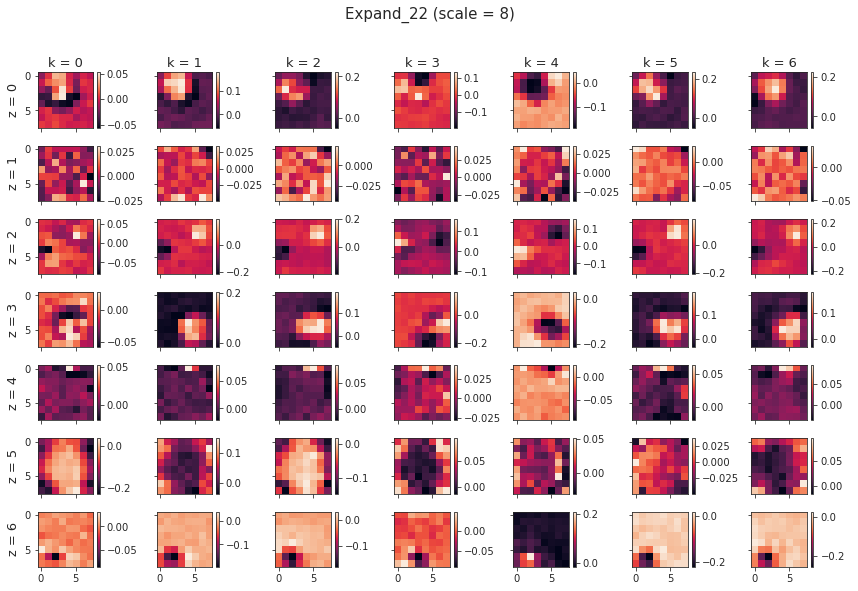

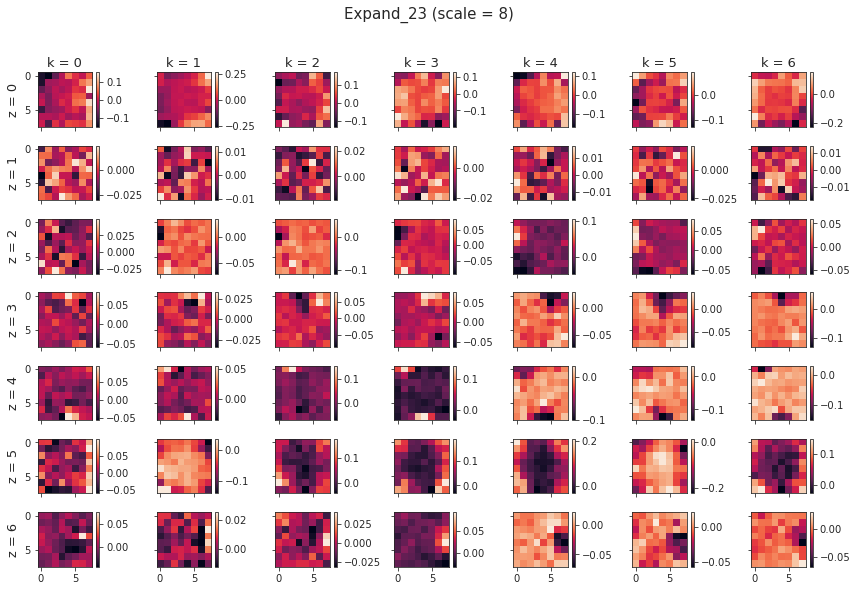

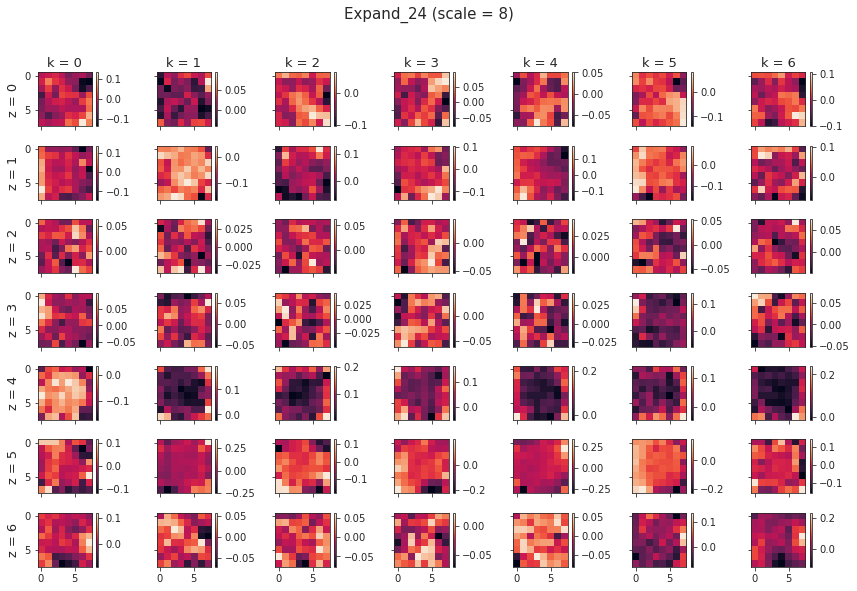

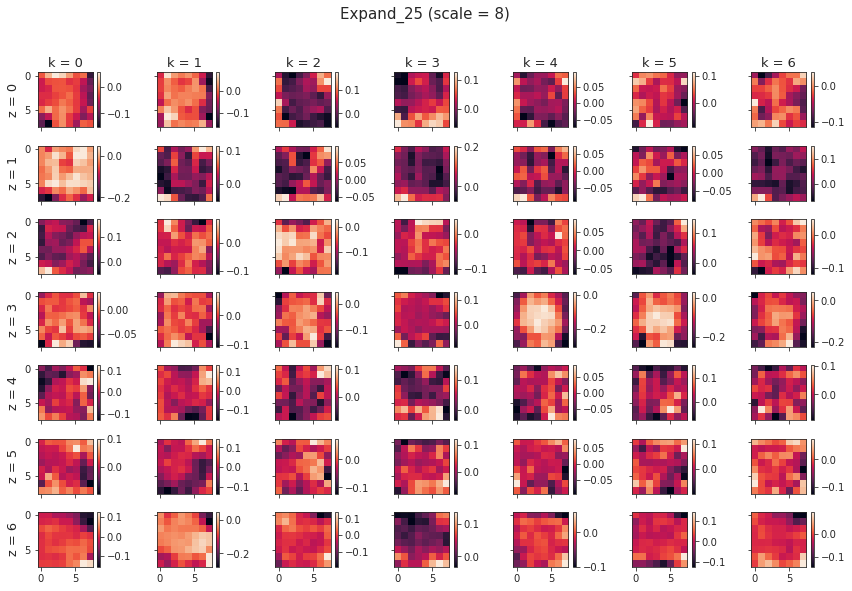

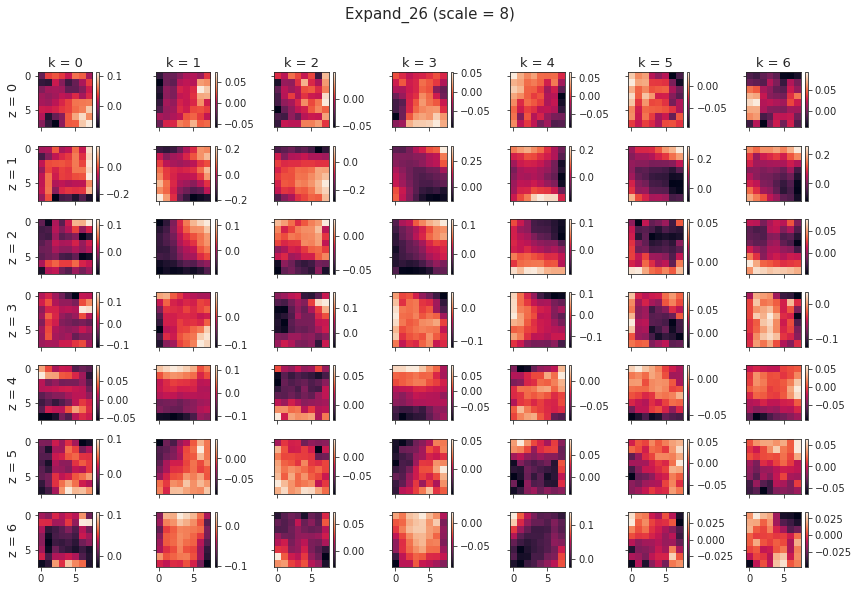

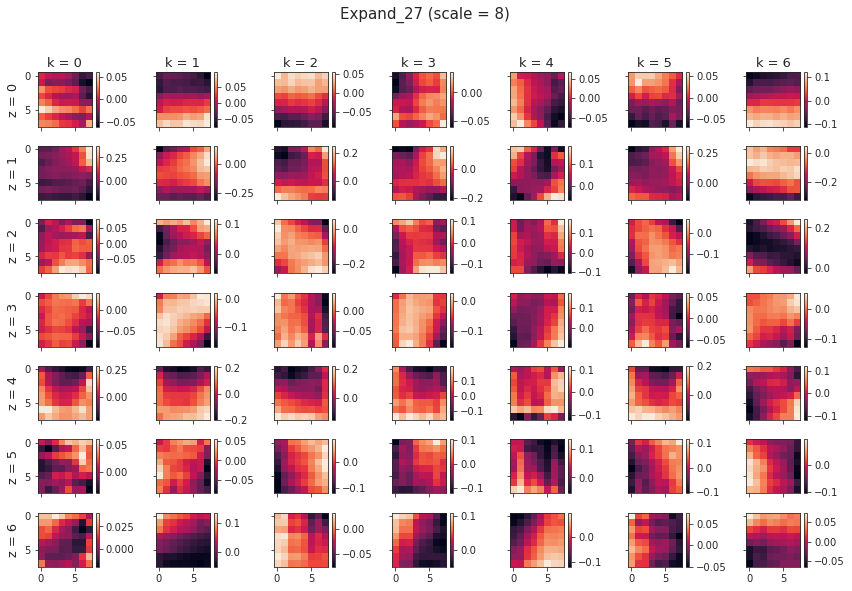

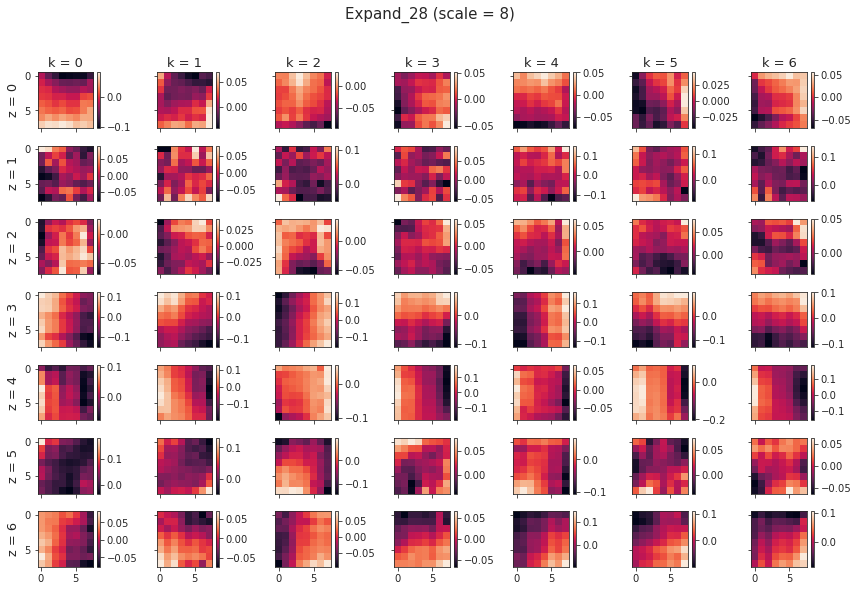

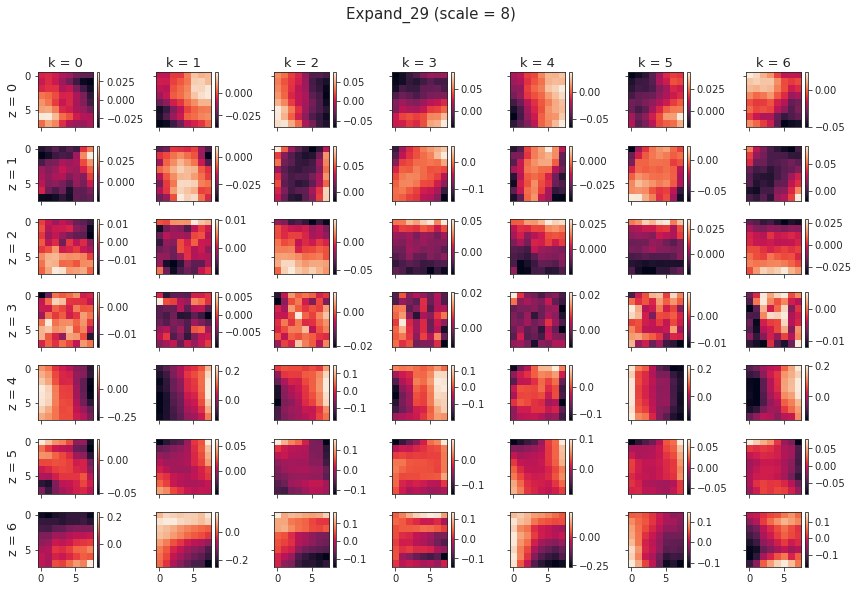

In [23]:
scales, _ = tr.model.latent_scales()
num = tr.model.cfg.n_latent_per_group

for i, _w in w2p.items():
    fig, axes = create_figure(num, num, (12, 8), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        im = ax.imshow(_w[z, k])
        plt.colorbar(im, ax=ax)
        if z == 0:
            ax.set_title(f"k = {k}", fontsize=13)
        if k == 0:
            ax.set_ylabel(f"z = {z}", fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()

## Regress more

In [37]:
%%time

regr = tr.regress(10, True)
print('ema', np.diag(regr['regr/r']).mean(), np.max(regr['regr/mi'], axis=1).mean())

ema 0.8452762965720829 0.4185117679696479

CPU times: user 45.3 s, sys: 7.46 s, total: 52.7 s
Wall time: 55.8 s


In [38]:
%%time

regr = tr.regress(10, False)
print('ema', np.diag(regr['regr/r']).mean(), np.max(regr['regr/mi'], axis=1).mean())

ema 0.8377418239422382 0.41414621700351756

CPU times: user 47 s, sys: 7.56 s, total: 54.5 s
Wall time: 54.4 s


In [39]:
%%time

regr = tr.regress(0, True)
print('ema', np.diag(regr['regr/r']).mean(), np.max(regr['regr/mi'], axis=1).mean())

ema 0.8671035738652683 0.5547808519290544

CPU times: user 6.69 s, sys: 2.8 s, total: 9.49 s
Wall time: 12.9 s


In [42]:
np.diag(regr['regr/r'])

array([0.97269555, 0.96671664, 0.95294767, 0.96441726, 0.9791492 ,
       0.86130813, 0.85880732, 0.65880006, 0.78909153, 0.76326918,
       0.77093677])

In [41]:
np.max(regr['regr/mi'], axis=1)

array([0.89852668, 1.0056554 , 0.5219623 , 0.63130417, 0.44074901,
       0.72688848, 0.74948892, 0.13927916, 0.45560887, 0.42111924,
       0.11200714])

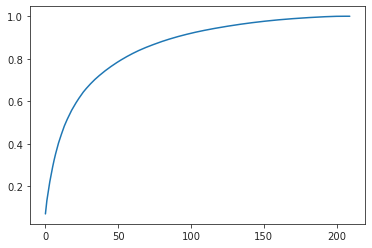

In [50]:
s = regr['regr/lr'].singular_ / regr['regr/lr'].singular_.sum()
plt.plot(np.cumsum(s))

In [52]:
regr['regr/lr'].coef_.shape

(11, 210)

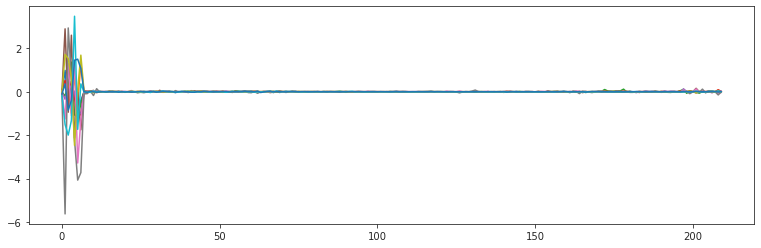

In [70]:
fig, ax = create_figure(1, 1, (13, 4))
plt.plot(regr['regr/lr'].coef_.T);

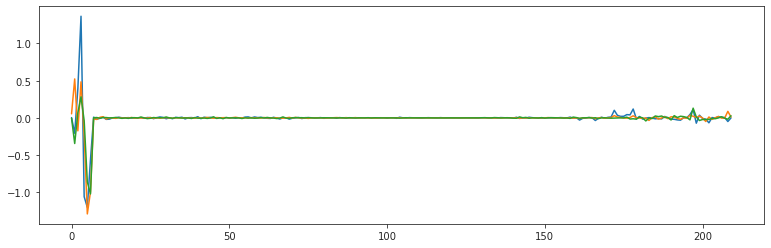

In [73]:
fig, ax = create_figure(1, 1, (13, 4))
plt.plot(regr['regr/lr'].coef_[2:5].T);

In [104]:
data, loss = tr.forward('vld', True, True)

In [105]:
loss

{'epe': array([1.723436 , 1.4769427, 2.7228832, ..., 1.2695841, 4.0226417,
        1.3457608], dtype=float32),
 'kl': array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)}

In [110]:
data['z'].shape

(7500, 210)

<AxesSubplot:ylabel='Count'>

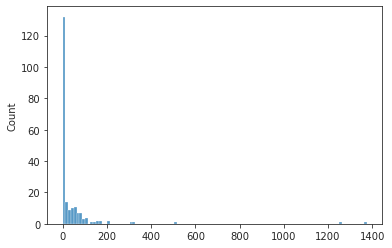

In [113]:
sns.histplot(data['z'].var(0))

In [116]:
from analysis.regression import regress

kws = dict(freeze=True, use_ema=True)
z_vld = tr.forward('vld', **kws)[0]['z']
z_tst = tr.forward('tst', **kws)[0]['z']

g_vld = tr.dl_vld.dataset.factors
g_tst = tr.dl_tst.dataset.factors
mi, r, lr = regress(z_vld, g_vld, z_tst, g_tst)

In [118]:
z_vld.shape

(7500, 210)

In [120]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0)
rf.fit(z_vld, g_vld)

RandomForestRegressor(random_state=0)

In [122]:
g_pred = rf.predict(z_tst)

In [123]:
r_from_rf = 1 - sp_dist.cdist(
    XA=g_tst.T,
    XB=g_pred.T,
    metric='correlation',
)

In [126]:
np.diag(r_from_rf)

array([0.92911016, 0.92659913, 0.80671915, 0.7423282 , 0.80314558,
       0.84290396, 0.86341454, 0.74549731, 0.70885296, 0.70800081,
       0.4301666 ])

In [197]:
from sklearn import linear_model
from sklearn import model_selection

In [200]:
reg = linear_model.MultiTaskLassoCV(
    cv=5,
    eps=1e-3,
    n_alphas=100,
    random_state=0,
).fit(z_vld, g_vld)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:2441: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.30489349365234, tolerance: 1.7365280389785767
  ) = cd_fast.enet_coordinate_descent_multi_task(


In [205]:
reg.score(z_vld, g_vld), reg.score(z_tst, g_tst), reg.alpha_

(0.7635080226945657, 0.751750772627052, 0.009135907291666665)

In [207]:
r2_score(g_vld, reg.predict(z_vld)), r2_score(g_tst, reg.predict(z_tst))

(0.7635080226945657, 0.751750772627052)

In [345]:
ridge = linear_model.RidgeCV(
    cv=5,
    alphas=np.logspace(-3, 1, num=200),
).fit(z_vld, g_vld)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.68918e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.14375e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.20328e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.34286e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.78778e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.24383e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.30293e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.44419e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.5844e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.03099e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.94761e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.40598e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.66421e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.8116e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.2498e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.17932e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.51541e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.98201e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.00378e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.01915e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.0078e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.05526e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.06056e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.0769e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linea

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.09349e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.14211e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.14698e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.1648e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.22423e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.27462e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.27878e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.29884e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.42434e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.47741e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.4804e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.50385e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.73187e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.7889e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.78998e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.81838e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.23841e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.13967e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.20662e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.26945e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.84406e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.91417e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.90789e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.9534e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.78766e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.86782e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.85524e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.91463e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.18537e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.27902e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.25768e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.33705e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.33058e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.43845e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.19267e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.57209e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.0769e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.09068e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.08558e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.10109e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.55559e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.57714e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.53175e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.61805e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.21051e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.33624e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.35847e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.34775e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.38178e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.41066e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.39573e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.43935e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/lin

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.85639e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.1336e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.17331e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.15152e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/line

In [346]:
ridge.score(z_vld, g_vld), ridge.score(z_tst, g_tst), ridge.alpha_

(0.7798212852544438, 0.7627428167655504, 0.01933891750455231)

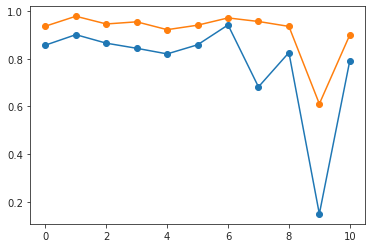

In [362]:
corr = []
r2 = []
for i in range(11):
    corr.append(sp_stats.pearsonr(g_tst[i], ridge.predict(z_tst)[i])[0])
    r2.append(r2_score(g_tst[i], ridge.predict(z_tst)[i]))
plt.plot(r2, marker='o')
plt.plot(corr, marker='o')

In [365]:
np.mean(corr), np.mean(r2)

(0.9141036924256515, 0.776272493648793)

In [367]:
lr = linear_model.LinearRegression().fit(z_vld, g_vld)
pred = lr.predict(z_tst)

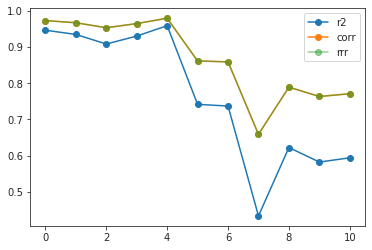

In [431]:
corr = []
r2 = []
for i in range(11):
    corr.append(sp_stats.pearsonr(g_tst[:, i], pred[:, i])[0])
    r2.append(r2_score(g_tst[:, i], pred[:, i]))
rrr = 1 - sp_dist.cdist(g_tst.T, pred.T, 'correlation')

plt.plot(r2, marker='o', label='r2')
plt.plot(corr, marker='o', label='corr')
plt.plot(np.diag(rrr), marker='o', alpha=0.5, label='rrr')
plt.legend();

In [433]:
np.mean(corr), np.mean(r2)

(0.867103573865268, 0.7626154478269463)

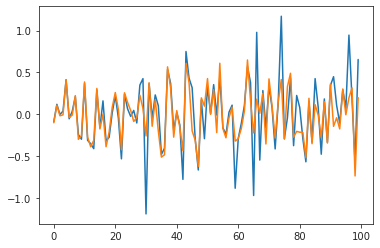

In [391]:
plt.plot(g_tst[:100, 9])
plt.plot(pred[:100, 9])

In [392]:
i = 9
sp_stats.pearsonr(g_tst[i], pred[i])

(0.6088404734253601, 0.04681089119506558)

In [414]:
1 - sp_dist.correlation(g_tst[i], pred[i].astype(float))

0.6088404734253601

In [424]:
1 - sp_dist.cdist(g_tst[:, [i]].T, pred[:, [i]].T.astype(float), metric='correlation')

array([[0.76326918]])

In [412]:
1 - np.diag(sp_dist.cdist(g_tst.T, pred.T.astype(float), metric='correlation'))

array([0.97269555, 0.96671664, 0.95294767, 0.96441726, 0.9791492 ,
       0.86130813, 0.85880732, 0.65880006, 0.78909153, 0.76326918,
       0.77093677])

In [411]:
np.diag(sp_dist.cdist(g_tst.T, pred.T, metric='correlation'))

array([0.02730445, 0.03328336, 0.04705233, 0.03558274, 0.0208508 ,
       0.13869187, 0.14119268, 0.34119994, 0.21090847, 0.23673082,
       0.22906323])

In [415]:
a = g_tst[i]
b = pred[i]

In [418]:
a

array([ 0.00997238,  0.93053386, -0.13429532,  0.16313858, -0.1751756 ,
        1.46478463,  0.20795294,  0.96866587,  0.65424187, -0.30029344,
        0.86645511])

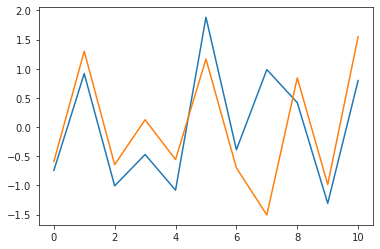

In [417]:
plt.plot(sp_stats.zscore(a))
plt.plot(sp_stats.zscore(b))

In [380]:
np.mean(corr), np.mean(r2), np.diag(rrr).mean()

(0.9136946560761217, 0.7739835630164434, 0.8671035738652683)

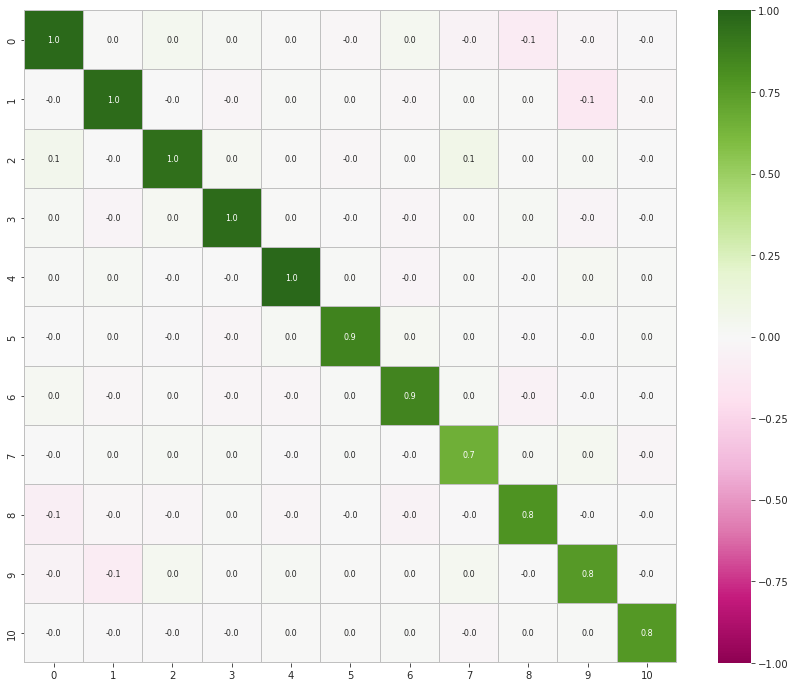

In [382]:
show_heatmap(r, cmap='PiYG');

In [377]:
corr

[0.9355917149227605,
 0.9788201649666207,
 0.9466248013025077,
 0.9555621810999154,
 0.9214489673622599,
 0.941305873064551,
 0.9707268421797348,
 0.9559664346411335,
 0.9381403102552137,
 0.6088404734253601,
 0.8976134536172802]

<AxesSubplot:ylabel='Count'>

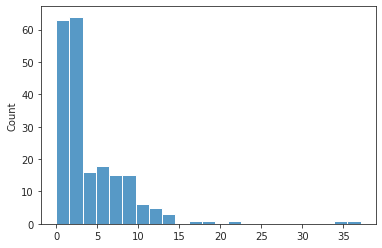

In [348]:
sns.histplot(z_vld.std(0))

In [349]:
z_vld.std(0).shape

(210,)

In [350]:
w = ridge.coef_ * z_vld.std(0, keepdims=True)

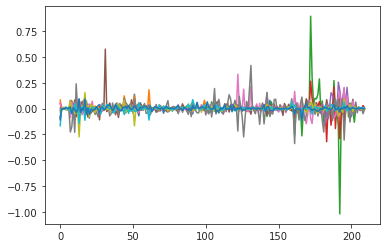

In [351]:
plt.plot(w.T);

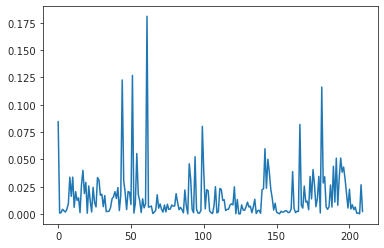

In [352]:
plt.plot(np.abs(w)[1]);

In [287]:
reg = linear_model.MultiTaskLassoCV(
    cv=5,
    eps=1e-4,
    n_alphas=200,
    random_state=0,
).fit(z_vld, g_vld)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3943449258804321, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4434914588928223, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4927167892456055, tolerance: 1.3827462196350098
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skl

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.423608660697937, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4936397075653076, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.54916250705719, tolerance: 1.394180178642273
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/l

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5452264547348022, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6175638437271118, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6989045143127441, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skl

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5209736824035645, tolerance: 1.3907557725906372
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4022927284240723, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4657466411590576, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skl

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.831045627593994, tolerance: 1.3807060718536377
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4548351764678955, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5099276304244995, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skle

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2462892532348633, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3295273780822754, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:625: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.546316623687744, tolerance: 1.3974210023880005
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/hadi/anaconda3/lib/python3.8/site-packages/skle

In [288]:
reg.score(z_vld, g_vld), reg.score(z_tst, g_tst), reg.alpha_

(0.7764304351941763, 0.7611910375139587, 0.0018291916976247706)

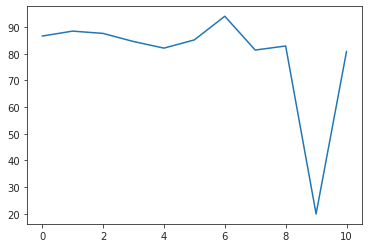

In [343]:
r2 = []
for i in range(11):
    r2.append(r2_score(g_tst[i], reg.predict(z_tst)[i]) * 100)
plt.plot(r2)

In [289]:
w = reg.coef_ * z_vld.std(0, keepdims=True)

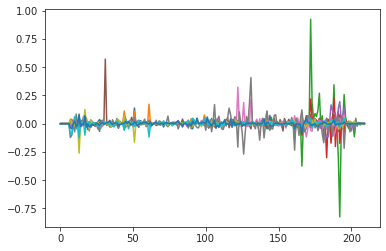

In [290]:
plt.plot(w.T);

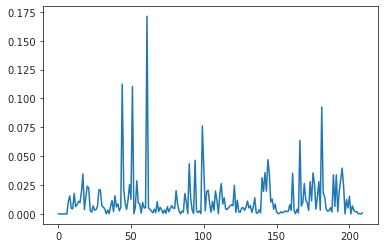

In [319]:
plt.plot(np.abs(w[1]));

In [190]:
lr = linear_model.LinearRegression().fit(z_vld, g_vld)

r_from_lr = 1 - sp_dist.cdist(
    XA=g_tst.T,
    XB=lr.predict(z_tst).T,
    metric='correlation',
)
np.diag(r_from_lr)

array([0.97269555, 0.96671664, 0.95294767, 0.96441726, 0.9791492 ,
       0.86130813, 0.85880732, 0.65880006, 0.78909153, 0.76326918,
       0.77093677])

In [195]:
lr_lasso = linear_model.Lasso(
    alpha=0.01,
    random_state=0,
).fit(z_vld, g_vld)

r_from_lasso = 1 - sp_dist.cdist(
    XA=g_tst.T,
    XB=lr_lasso.predict(z_tst).T,
    metric='correlation',
)
np.diag(r_from_lasso)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e+01, tolerance: 8.313e-02
  model = cd_fast.enet_coordinate_descent(


array([0.96501626, 0.95937836, 0.93825189, 0.96015753, 0.97229755,
       0.86158773, 0.8585379 , 0.65224168, 0.77880439, 0.75146596,
       0.71142585])

In [186]:
lr_ridge = linear_model.Ridge(
    alpha=1,
    random_state=0,
).fit(z_vld, g_vld)

r_from_ridge = 1 - sp_dist.cdist(
    XA=g_tst.T,
    XB=lr_ridge.predict(z_tst).T,
    metric='correlation',
)
np.diag(r_from_ridge)

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.51754e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


array([0.97262022, 0.96663686, 0.95296357, 0.96444935, 0.97913275,
       0.8613393 , 0.85910071, 0.66020277, 0.78923802, 0.76231219,
       0.76979944])

array([0.97269555, 0.96671664, 0.95294767, 0.96441726, 0.9791492 ,
       0.86130813, 0.85880732, 0.65880006, 0.78909153, 0.76326918,
       0.77093677])

## TMP: def r(self, x):

In [7]:
from model.common import endpoint_error
from model.distributions import Normal
from model.vae2d import CombinerEnc, CombinerDec

In [9]:
x, norm = next(iter(tr.dl_tst))
z, ftr_enc, ftr_dec, y, q, p = tr.model_ema.xtract_ftr(x, t=0)

nf_enc = {s: len(f) for s, f in ftr_enc.items()}
nf_dec = {s: len(f) for s, f in ftr_dec.items()}
print(f"num ftrs enc: {nf_enc}\nnum ftrs dec: {nf_dec}")

num ftrs enc: {8: 40, 4: 21}
num ftrs dec: {4: 18, 8: 41}

In [10]:
endpoint_error(x, y).mean()

tensor(1.6867, device='cuda:1')

In [12]:
e8 = np.concatenate(ftr_enc[8], 1)
d8 = np.concatenate(ftr_dec[8], 1)
e4 = np.concatenate(ftr_enc[4], 1)
d4 = np.concatenate(ftr_dec[4], 1)
e8.shape, d8.shape, e4.shape, d4.shape

((512, 2560, 8, 8), (512, 2624, 8, 8), (512, 2688, 4, 4), (512, 2304, 4, 4))

In [24]:
len(ftr_enc[8]), len(ftr_dec[8])

(40, 41)

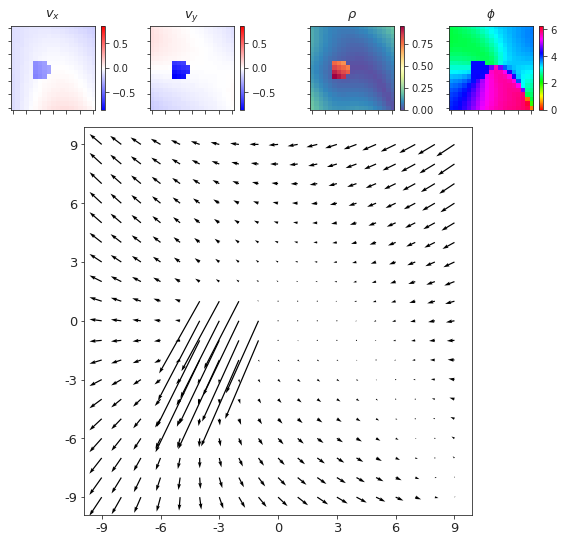

In [34]:
i = 0
show_opticflow_full(x[i]);

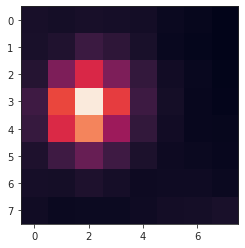

In [35]:
plt.imshow(np.abs(e8[i]).mean(0))

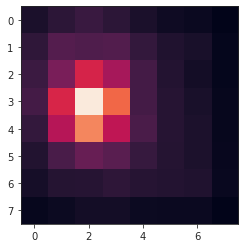

In [36]:
plt.imshow(np.abs(d8[i]).mean(0))

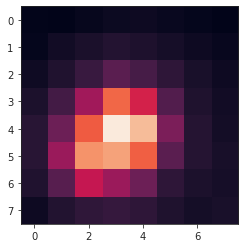

In [77]:
plt.imshow(np.abs(r8[i]).mean(0))

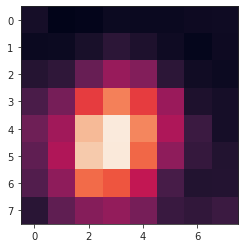

In [78]:
plt.imshow(np.maximum(0, r8[i]).mean(0))

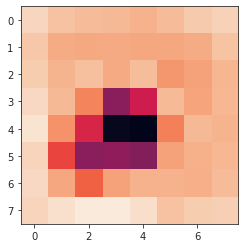

In [79]:
plt.imshow(r8[i].mean(0))

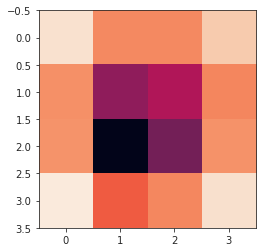

In [80]:
plt.imshow(r4[i].mean(0))

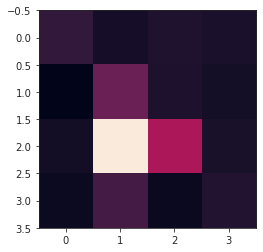

In [81]:
plt.imshow(np.maximum(0, r4[i]).mean(0))

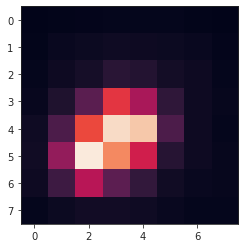

In [82]:
plt.imshow(r8[i].var(0))

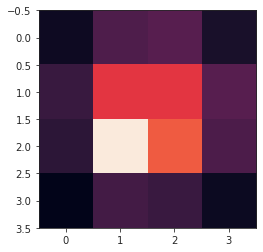

In [83]:
plt.imshow(r4[i].var(0))

In [37]:
e8.shape, d8.shape

((512, 2560, 8, 8), (512, 2624, 8, 8))

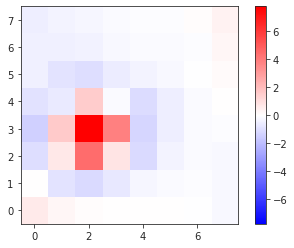

In [70]:
x2p = e8[i, 250]
vminmax = np.max(np.abs(x2p))
fig, ax = create_figure()
im = ax.imshow(x2p, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

In [71]:
x2p.shape

(8, 8)

In [72]:
np.argsort(np.abs(d8[i] - np.expand_dims(x2p, 0)).sum(-1).sum(-1))

array([2036, 2100, 1940, ...,   31,   95,  159])

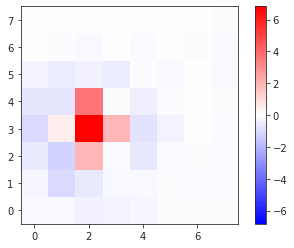

In [74]:
x2p = d8[i, 2100]
vminmax = np.max(np.abs(x2p))
fig, ax = create_figure()
im = ax.imshow(x2p, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

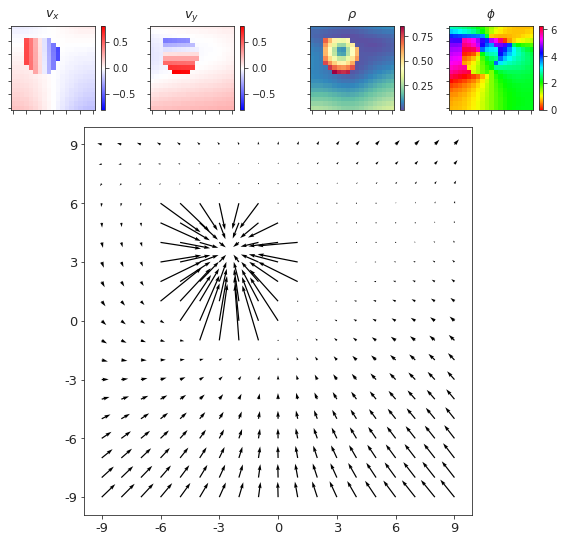

In [120]:
show_opticflow_full(x[7]);

In [137]:
def repres(
        self,
        dl: str,
        t: float = 0,
        use_ema: bool = False, ):
    assert dl in ['trn', 'vld', 'tst']
    dl = getattr(self, f"dl_{dl}")
    if dl is None:
        return
    model = self.select_model(use_ema)

    x_all, y_all, z_all = [], [], []
    l1, l2, epe, kl = [], [], [], []
    for i, (x, norm) in enumerate(dl):
        if x.device != self.device:
            x, norm = self.to([x, norm])
        _, z, *_ = model.xtract_ftr(x, t=t)
        z = torch.cat(z, dim=1).squeeze()
        z_all.append(to_np(z))

    return np.concatenate(z_all)

In [138]:
%%time

z_tst = repres(tr, 'tst', True)
z_vld = repres(tr, 'vld', True)

CPU times: user 6.91 s, sys: 632 ms, total: 7.54 s
Wall time: 7.54 s


In [82]:
g_vld = tr.dl_vld.dataset.factors
g_tst = tr.dl_tst.dataset.factors

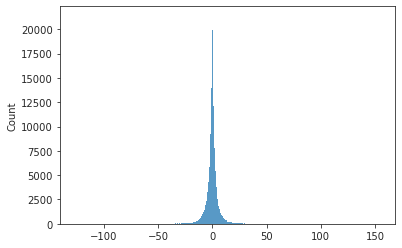

In [140]:
sns.histplot(z_vld.ravel());

In [141]:
z_vld.shape

(7500, 210)

In [142]:
# from analysis.regression import regress
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression

def regress(z, g, z_tst, g_tst):
    # mi regression
    mi = np.zeros((g.shape[-1], z.shape[-1]))
    # for i in range(len(mi)):
    #     mi[i] = mutual_info_regression(z, g[:, i])
    # linear regression
    lr = linear_model.LinearRegression().fit(z, g)
    r = 1 - sp_dist.cdist(
        XA=g_tst.T,
        XB=lr.predict(z_tst).T,
        metric='correlation',
    )
    return mi, r, lr

mi, rr, lr = regress(z_vld, g_vld, z_tst, g_tst)

In [143]:
np.diag(rr)

array([0.92512674, 0.90689993, 0.87940288, 0.9281913 , 0.8212474 ,
       0.85449239, 0.87752674, 0.70255081, 0.87056153, 0.8422471 ,
       0.64396748])

In [76]:
np.diag(val_ema['regr/r'])

array([0.94135484, 0.92973866, 0.90059408, 0.94560584, 0.82830015,
       0.85378562, 0.86509301, 0.67792185, 0.8526114 , 0.82099003,
       0.6394755 ])

In [85]:
%%time

n_fwd = 10
use_ema = True
z_vld, z_tst = [], []
for _ in range(n_fwd):
    zv = tr.forward('vld', False, use_ema)[0]['z']
    zt = tr.forward('tst', False, use_ema)[0]['z']
    z_vld.append(np.expand_dims(zv, 0))
    z_tst.append(np.expand_dims(zt, 0))
    
z_vld, z_tst = cat_map([z_vld, z_tst])
z_vld = z_vld.mean(0)
z_tst = z_tst.mean(0)

CPU times: user 40 s, sys: 5.02 s, total: 45 s
Wall time: 44.9 s


In [89]:
mi, rr, lr = regress(z_vld, g_vld, z_tst, g_tst)

In [90]:
np.diag(rr)

array([0.94240732, 0.93018334, 0.89773044, 0.94760517, 0.8267325 ,
       0.85470746, 0.86887434, 0.68998536, 0.85006285, 0.83255921,
       0.63718095])

In [91]:
np.diag(val_ema['regr/r'])

array([0.94135484, 0.92973866, 0.90059408, 0.94560584, 0.82830015,
       0.85378562, 0.86509301, 0.67792185, 0.8526114 , 0.82099003,
       0.6394755 ])

In [92]:
%%time

n_fwd = 100
use_ema = True
z_vld, z_tst = [], []
for _ in range(n_fwd):
    zv = tr.forward('vld', False, use_ema)[0]['z']
    zt = tr.forward('tst', False, use_ema)[0]['z']
    z_vld.append(np.expand_dims(zv, 0))
    z_tst.append(np.expand_dims(zt, 0))
    
z_vld, z_tst = cat_map([z_vld, z_tst])
z_vld = z_vld.mean(0)
z_tst = z_tst.mean(0)

CPU times: user 6min 51s, sys: 58.2 s, total: 7min 49s
Wall time: 7min 49s


In [93]:
mi, rrr, lr = regress(z_vld, g_vld, z_tst, g_tst)
np.diag(rrr)

array([0.94564019, 0.93695063, 0.90010376, 0.9475873 , 0.82723381,
       0.86777176, 0.88216196, 0.73312985, 0.86586815, 0.84687005,
       0.68640429])

In [94]:
np.diag(rrr).mean()

0.8581565229504179

In [96]:
np.diag(val_ema['regr/r']).mean()

0.8414064524314434